In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import gseapy as gp
import statsmodels.api as sm
from adjustText import adjust_text

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
DF_HOM = pd.read_csv(DATA_PATH+'/gene_annotation/mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_top1000_zscore.74_traits.rv1.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_tcell.rv1'

# Set score file
DIC_SCORE_PATH = {'tms_facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore'}

# Set trait list
TRAIT_LIST_TCELL = ['PASS_IBD_deLange2017', 'PASS_CD_deLange2017','PASS_UC_deLange2017',
                    'PASS_Rheumatoid_Arthritis', 'PASS_Multiple_sclerosis', 'UKB_460K.disease_AID_ALL',
                    'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED',
                    'UKB_460K.disease_ASTHMA_DIAGNOSED', 'UKB_460K.disease_RESPIRATORY_ENT']

In [14]:
# # Curate gold standard gene sets 
# df_gold = DF_TRAIT_INFO[['Trait_Identifier', 'Code']].copy()

# # Drug targets 
# df_drug = pd.read_excel(DATA_PATH+'/gene_annotation/drug-target.xlsx')
# df_drug.index = df_drug['Trait_Identifier']
# # Change PASS_BIP_Stahl2019 to PASS_BIP_Mullins2021
# df_drug.loc['PASS_BIP_Mullins2021'] = df_drug.loc['PASS_BIP_Stahl2019']
# df_drug.drop('PASS_BIP_Stahl2019', inplace=True)
# df_drug['n_gene'] = [len(x.split(',')) if type(x)==str else 0 for x in df_drug['target_genes']]
# df_drug = df_drug.loc[df_drug['n_gene']>=10].copy()
# df_drug = df_drug.loc[~df_drug['target_genes'].isna(), ['EFO', 'EFO_label', 'target_genes', 'n_gene']].copy()
# df_drug.columns = ['EFO', 'EFO_label', 'Drug_Target_Geneset', 'N_Drug_Target']
# df_gold = df_gold.join(df_drug)

# # Mendelian genes 
# df_men = pd.read_csv(DATA_PATH+'/gold_standard_gs/Freund_AJHG_2018.gs', sep='\t', index_col=0)
# dic_trait_map = {'Immune_Dysregulation': ['PASS_CD_deLange2017', 'PASS_Celiac', 'PASS_IBD_deLange2017',
#                                           'PASS_Multiple_sclerosis', 'PASS_Primary_biliary_cirrhosis',
#                                           'PASS_Rheumatoid_Arthritis', 'PASS_UC_deLange2017', 'PASS_Lupus',
#                                           'UKB_460K.disease_AID_ALL', 
#                                           'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 
#                                           'UKB_460K.disease_ASTHMA_DIAGNOSED',
#                                           'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 
#                                           'UKB_460K.disease_RESPIRATORY_ENT'],
#                  'Hematologic_Disorder': ['UKB_460K.blood_MEAN_CORPUSCULAR_HEMOGLOBIN', 
#                                           'UKB_460K.blood_RBC_DISTRIB_WIDTH', 'UKB_460K.blood_RED_COUNT'],
#                  'Growth_Defect': ['UKB_460K.body_HEIGHTz'],
#                  'Bone_and_Uric_Acid_Disorder': ['UKB_460K.bmd_HEEL_TSCOREz'],
#                  'Disorders_of_Platelet_Function': ['UKB_460K.blood_PLATELET_COUNT'],
#                  'Cardiovascular_Disease': ['PASS_Coronary_Artery_Disease',
#                                             'UKB_460K.disease_CARDIOVASCULAR',
#                                             'UKB_460K.biochemistry_Cholesterol', 
#                                             'UKB_460K.biochemistry_HDLcholesterol', 
#                                             'UKB_460K.biochemistry_LDLdirect', 
#                                             'UKB_460K.biochemistry_Triglycerides'],
#                  'Monogenic_Diabetes': ['UKB_460K.biochemistry_HbA1c', 'PASS_Type_2_Diabetes'],
#                  'Insulin_Disorder': ['PASS_FastingGlucose_Manning'],
#                  'MODY': ['UKB_460K.biochemistry_Glucose', 'PASS_Type_1_Diabetes'],
#                  'Female_Reproductive_Disorder': ['UKB_460K.repro_MENARCHE_AGE', 
#                                                   'UKB_460K.repro_MENOPAUSE_AGE'],
#                  'Neurologic_Disorder': ['PASS_ADHD_Demontis2018', 'PASS_Alzheimers_Jansen2019', 
#                                          'PASS_MDD_Howard2019', 'UKB_460K.mental_NEUROTICISM'],
#                  'Psychiatric_Disorder': ['PASS_BIP_Mullins2021', 'PASS_Schizophrenia_Pardinas2018'],
#                  'Arrythmia': ['PASS_AtrialFibrillation_Nielsen2018'],
#                  'Education_and_Development_Disorder': ['UKB_460K.cov_EDU_COLLEGE',
#                                                         'UKB_460K.cov_EDU_YEARS'],
#                  'Positive_Mood_Disorder': ['PASS_SWB', 'PASS_Worry_Nagel2018'],
#                  'Body_Mass_Disorder': ['UKB_460K.body_BMIz', 'UKB_460K.body_WHRadjBMIz']}
# df_gold['Matched_Mendelian_Disorder'] = ''
# for term in dic_trait_map:
#     df_gold.loc[dic_trait_map[term], 'Matched_Mendelian_Disorder'] = term
# df_gold['Mendelian_Geneset'] = [df_men.loc[x, 'GENESET'] if x in df_men.index else np.nan
#                                 for x in df_gold['Matched_Mendelian_Disorder']]
# df_gold['N_Mendelian'] = [len(x.split(',')) if type(x)==str else 0 for x in df_gold['Mendelian_Geneset']]
# df_gold.fillna('', inplace=True)
# df_gold = df_gold.loc[(df_gold['Drug_Target_Geneset']!='') | (df_gold['Mendelian_Geneset']!='')]

# df_gold.to_csv(DATA_PATH+'/gold_standard_gs/drug_and_mendelian.rv1.tsv', sep='\t', index=False)

# print('%s traits with drug targets'%(df_gold['Drug_Target_Geneset']!='').sum())
# print('%s traits with Mendelian genes'%(df_gold['Mendelian_Geneset']!='').sum())

27 traits with drug targets
45 traits with Mendelian genes


### Load data 

In [3]:
# Load TMS data 
adata = dl.load_tms_ct(DATA_PATH, data_name='facs')
adata_tcell = read_h5ad(DATA_PATH+'/single_cell_data/tms_proc/tcell.facs.annot.h5ad')

Trying to set attribute `.obs` of view, copying.


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in TRAIT_LIST_TCELL:
        file_path = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)       

### Analysis 

In [5]:
BACKGRD_SET = set(adata.var_names) & set(DIC_MAP_H2M.values())
GENE_LIST = sorted(BACKGRD_SET)
print('gene_list=%d, trait_list=%d'%(len(GENE_LIST), len(TRAIT_LIST_TCELL)))

# Load gold standard gene set
DF_GOLD = pd.read_csv(DATA_PATH+'/gold_standard_gs/drug_and_mendelian.rv1.tsv', sep='\t', index_col=0)
TRAIT_LIST_GOLD = list(DF_GOLD.index)
print('%d drug target gene sets mapped to %d traits: %d-%d genes'
      %(len(set(DF_GOLD.loc[~DF_GOLD['Drug_Target_Geneset'].isna(),'EFO'])), 
        (~DF_GOLD['Drug_Target_Geneset'].isna()).sum(), 
        np.min([len(x.split(',')) for x in DF_GOLD['Drug_Target_Geneset'] if type(x)==str]),
        np.max([len(x.split(',')) for x in DF_GOLD['Drug_Target_Geneset'] if type(x)==str])))
print('%d Mendelian disease gene sets mapped to %d traits: %d-%d genes'
      %(len(set(DF_GOLD.loc[~DF_GOLD['Mendelian_Geneset'].isna(),'Matched_Mendelian_Disorder'])), 
        (~DF_GOLD['Mendelian_Geneset'].isna()).sum(),
        np.min([len(x.split(',')) for x in DF_GOLD['Mendelian_Geneset'] if type(x)==str]),
        np.max([len(x.split(',')) for x in DF_GOLD['Mendelian_Geneset'] if type(x)==str])))

# Load MAGMA gene set 
DF_MAGMA = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/MAGMA-v108/'
                       'MAGMA_v108_GENE_10_PSTAT_for_scDRS.txt', sep='\t')
DF_MAGMA.index = [DIC_MAP_H2M[x] if x in DIC_MAP_H2M else 'non-map' for x in DF_MAGMA.index]
DF_MAGMA = DF_MAGMA.loc[DF_MAGMA.index!='non-map'].copy()

# Cell populations
DIC_TPOP = {'all_t': list(adata_tcell.obs_names),
            'cd4_t': list(adata_tcell.obs_names[adata_tcell.obs['dpt_cd4_qn']>=0]), 
            'cd8_t': list(adata_tcell.obs_names[adata_tcell.obs['dpt_cd8_qn']>=0])}
DIC_TPOP_NAME = {'all_t': 'all T cells', 'cd4_t': 'CD4+ T cells', 'cd8_t': 'CD8+ T cells'}
for term in DIC_TPOP:
    print('%s n_cell=%d'%(term, len(DIC_TPOP[term])))

gene_list=14807, trait_list=10
27 drug target gene sets mapped to 27 traits: 10-410 genes
16 Mendelian disease gene sets mapped to 45 traits: 69-723 genes
all_t n_cell=3769
cd4_t n_cell=1686
cd8_t n_cell=2197


In [6]:
# scDRS correlation: precomputed correlation (across all cells) for 74 traits
df_corr_scdrs = pd.DataFrame(index=GENE_LIST)
for trait in TRAIT_LIST_GOLD:        
    temp_df = pd.read_csv(DATA_PATH+'/downstream_file/down_stream.tms_facs_with_cov.magma_10kb_top1000_zscore' 
                          '/%s.scdrs_gene'%trait, sep='\t', index_col=0)
    temp_list = sorted(BACKGRD_SET & set(temp_df.index))
    df_corr_scdrs[trait] = 0
    df_corr_scdrs.loc[temp_list, trait] = temp_df.loc[temp_list, 'CORR']

# scDRS correlation across T cells 
for tpop in DIC_TPOP:
    cell_list = DIC_TPOP[tpop].copy()    
    temp_adata = adata[cell_list, GENE_LIST].copy()
    mat_expr = temp_adata.X.toarray().copy()
    for trait in TRAIT_LIST_TCELL:        
        v_corr = md._pearson_corr(mat_expr, dic_score[score].loc[cell_list, '%s.norm_score'%trait].values)
        df_corr_scdrs['%s.%s'%(trait,tpop)] = v_corr

In [7]:
# GWAS and scDRS gene sets 
dic_gs = {}

# GWAS gene set
for trait in TRAIT_LIST_GOLD:
    dic_gs['%s.gwas'%trait] = set(
        [DIC_MAP_H2M[x] for x in [y.split(':')[0] for y in DF_GS.loc[trait, 'GENESET'].split(',')]
         if x in DIC_MAP_H2M]) & BACKGRD_SET
    
# scDRS gene sets       
for trait in TRAIT_LIST_GOLD:
    temp_df = df_corr_scdrs[[trait]].copy()
    temp_df.sort_values(by=[trait], ascending=False, inplace=True)
    dic_gs['%s.scdrs'%trait] = set(temp_df.index[:len(dic_gs['%s.gwas'%trait])])  

for trait in TRAIT_LIST_TCELL:
    for tpop in DIC_TPOP:    
        temp_df = df_corr_scdrs[['%s.%s'%(trait,tpop)]].copy()
        temp_df.sort_values(by=['%s.%s'%(trait,tpop)], ascending=False, inplace=True)
        dic_gs['%s.%s.scdrs'%(trait,tpop)] = set(temp_df.index[:len(dic_gs['%s.gwas'%(trait)])])
    
# T cell SEGs
tpop = 'all_t'
cell_list = DIC_TPOP[tpop].copy()
temp_adata = adata[:, GENE_LIST].copy()
temp_adata.obs['tcell'] = 'nt'
temp_adata.obs.loc[cell_list, 'tcell'] = 't'
sc.tl.rank_genes_groups(temp_adata, groupby='tcell', groups=['t'])
df_t = sc.get.rank_genes_groups_df(temp_adata, 't')
for trait in TRAIT_LIST_TCELL:     
    dic_gs['%s.%s.seg'%(trait,tpop)] = set(df_t['names'][:len(dic_gs['%s.gwas'%trait])])

# Gold standard gene set: drug targets
for trait in DF_GOLD.index[~DF_GOLD['Drug_Target_Geneset'].isna()]:
    dic_gs['%s.ref_drug'%trait] = set(
        [DIC_MAP_H2M[x] for x in DF_GOLD.loc[trait,'Drug_Target_Geneset'].split(',') 
         if x in DIC_MAP_H2M]) & BACKGRD_SET

# Gold standard gene set: Mendelian genes 
for trait in DF_GOLD.index[~DF_GOLD['Mendelian_Geneset'].isna()]:
    dic_gs['%s.ref_mende'%trait] = set(
        [DIC_MAP_H2M[x] for x in DF_GOLD.loc[trait,'Mendelian_Geneset'].split(',')
         if x in DIC_MAP_H2M]) & BACKGRD_SET
    
# Gold standard gene set: combining the two
for trait in TRAIT_LIST_TCELL:
    if '%s.ref_drug'%trait in dic_gs:
        dic_gs['%s.ref'%trait] = dic_gs['%s.ref_drug'%trait]
        print('Drug: %s, n_gene=%d'%(trait, len(DF_GOLD.loc[trait, 'Drug_Target_Geneset'].split(','))))
    else:
        dic_gs['%s.ref'%trait] = dic_gs['%s.ref_mende'%trait]
        print('Mendelian: %s, n_gene=%d'%(trait, len(DF_GOLD.loc[trait, 'Mendelian_Geneset'].split(','))))

/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tissue_celltype' as categorical
/n/holystore01/LABS/price_lab/Users/mjzhang/myenv_gf/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tcell' as categorical


Drug: PASS_IBD_deLange2017, n_gene=35
Drug: PASS_CD_deLange2017, n_gene=143
Drug: PASS_UC_deLange2017, n_gene=142
Drug: PASS_Rheumatoid_Arthritis, n_gene=223
Drug: PASS_Multiple_sclerosis, n_gene=250
Drug: UKB_460K.disease_AID_ALL, n_gene=82
Mendelian: UKB_460K.disease_HYPOTHYROIDISM_SELF_REP, n_gene=550
Drug: UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED, n_gene=27
Drug: UKB_460K.disease_ASTHMA_DIAGNOSED, n_gene=123
Mendelian: UKB_460K.disease_RESPIRATORY_ENT, n_gene=550


In [8]:
# Compute stats
dic_stats = {}
compute_list = [[x, 'ref'] for x in ['gwas', 'scdrs', 'all_t.scdrs', 'cd4_t.scdrs', 'cd8_t.scdrs', 'all_t.seg']]+\
    [[x, 'ref_drug'] for x in ['gwas', 'scdrs']] + \
    [[x, 'ref_mende'] for x in ['gwas', 'scdrs']]
for res,res_ref in compute_list:
    dic_stats['%s.%s'%(res,res_ref)] = pd.DataFrame(columns=['GWAS', 'GS', 'overlap', 'excess_overlap', 
                                                             'odds_ratio', 'odds_ratio.ub', 'odds_ratio.lb',
                                                             'pval', 'nlog10pval', 'overlap_gene'], 
                                                    dtype=float)
    for trait in [x.replace('.%s'%res_ref, '') for x in dic_gs if x.endswith(res_ref)]:
        if ('%s.%s'%(trait, res) not in dic_gs):
            continue
        gs_set = dic_gs['%s.%s'%(trait, res)] & BACKGRD_SET
        gs_set_ref = dic_gs['%s.%s'%(trait, res_ref)] & BACKGRD_SET
        pvalue,oddsratio,or_ub,or_lb = util.test_overlap(gs_set, gs_set_ref, BACKGRD_SET)

        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'GWAS'] = len(gs_set)
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'GS'] = len(gs_set_ref)
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'overlap'] = len(gs_set & gs_set_ref)
        excess_overlap = len(gs_set & gs_set_ref) * len(BACKGRD_SET) / len(gs_set) / len(gs_set_ref)
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'excess_overlap'] = excess_overlap
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'odds_ratio'] = oddsratio
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'odds_ratio.ub'] = or_ub
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'odds_ratio.lb'] = or_lb
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'pval'] = pvalue
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'nlog10pval'] = -np.log10(pvalue)
        dic_stats['%s.%s'%(res,res_ref)].loc[trait,'overlap_gene'] = ','.join(sorted(gs_set & gs_set_ref))

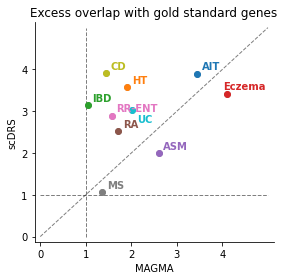

In [9]:
# Figure 
dic_name = {'gwas':'MAGMA', 'scdrs': 'scDRS', 'all_t.scdrs':'scDRS across T cells', 
            'cd4_t.scdrs':'scDRS across CD4+ T cells', 'cd8_t.scdrs':'scDRS across CD8+ T cells',
            'all_t.seg':'T cell SEGs', 'ref_drug': 'drug targets', 'ref_mende': 'Mendelian genes',
            'nlog10pval': '-log10 p-value for excess overlap', 'excess_overlap': 'Excess overlap'}
dic_config_trait = {'UKB_460K.disease_AID_ALL': ['C0'], 
                    'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP': ['C1'], 
                    'PASS_IBD_deLange2017': ['C2'], 
                    'PASS_CD_deLange2017': ['C8'], 
                    'PASS_UC_deLange2017': ['C9'], 
                    'PASS_Rheumatoid_Arthritis': ['C5'],
                    'UKB_460K.disease_RESPIRATORY_ENT': ['C6'],
                    'UKB_460K.disease_ASTHMA_DIAGNOSED': ['C4'],
                    'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED': ['C3'],
                    'PASS_Multiple_sclerosis':['C7'],
                   }

# Main Figure 
res_main,res_ref,plot_term = 'scdrs.ref','gwas.ref','excess_overlap'
plt.figure(figsize=[4,4])
ax = plt.subplot(1,1,1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
trait_list = list(dic_stats[res_main].index)
plt.scatter(dic_stats[res_ref].loc[trait_list, plot_term], 
            dic_stats[res_main].loc[trait_list, plot_term], color='k', alpha=0.2, zorder=5)
for trait in dic_config_trait:
    plt.scatter(dic_stats[res_ref].loc[trait, plot_term], dic_stats[res_main].loc[trait, plot_term], 
                color=dic_config_trait[trait][0], zorder=10)
    plt.text(dic_stats[res_ref].loc[trait, plot_term]+0.1 - 
             0.2*(trait in ['UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED']), 
             dic_stats[res_main].loc[trait, plot_term]+0.1 - 0.4*(trait in ['PASS_UC_deLange2017']),
             DF_TRAIT_INFO.loc[trait, 'Code'], color=dic_config_trait[trait][0],
             weight="bold", zorder=10)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
max_ = np.ceil(max(xmax, ymax)).astype(int)
step_ = max(1,int((max_ - 0)/5))
plt.plot([0, max_], [0, max_], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
plt.plot([0, max_], [1, 1], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
plt.plot([1, 1], [0, max_], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
plt.xlim([-max_*0.025, max_*1.025])
plt.ylim([-max_*0.025, max_*1.025])
plt.xlabel(dic_name[res_ref.replace('.ref','')])
plt.ylabel(dic_name[res_main.replace('.ref','')])
plt.xticks(np.arange(0, max_, step_), np.arange(0, max_, step_))
plt.yticks(np.arange(0, max_, step_), np.arange(0, max_, step_))
plt.title('Excess overlap with gold standard genes')
plt.tight_layout()
plt.savefig(FIG_PATH+'/comparison_gs_main.svg')
plt.show()

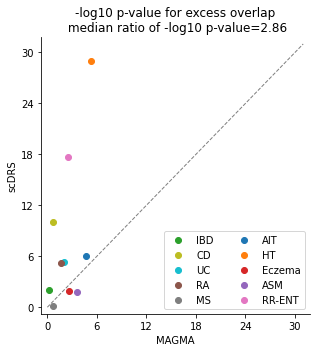

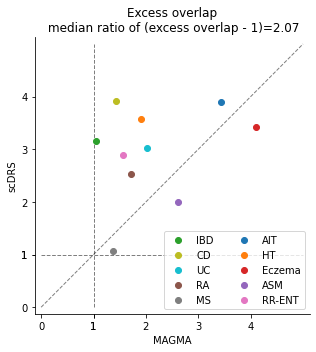

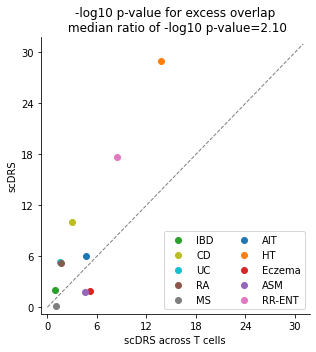

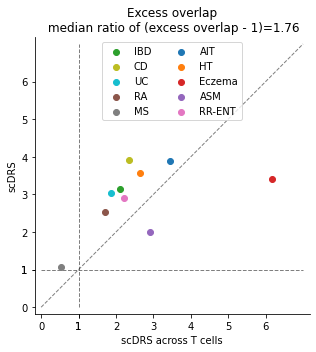

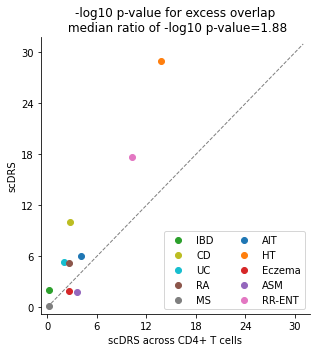

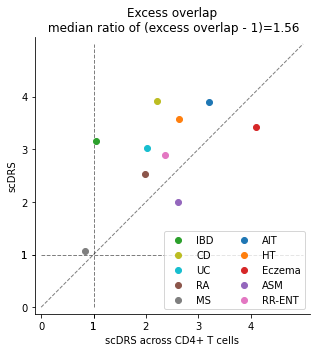

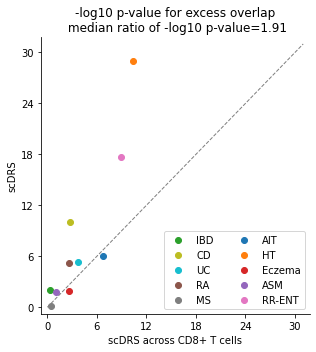

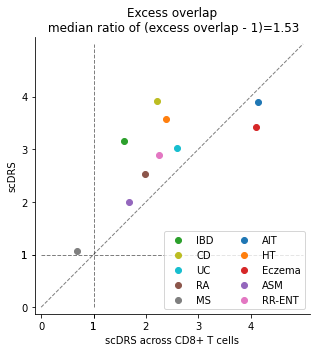

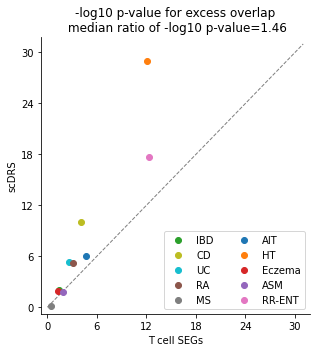

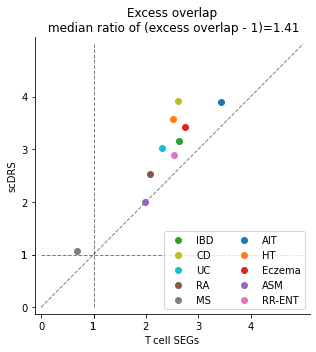

In [10]:
# All comparisons 
plot_list = []
res_main = 'scdrs.ref'    
for res_ref in [x for x in dic_stats.keys() if (x!=res_main) & (x.endswith('ref'))]:
    for term in ['nlog10pval', 'excess_overlap']:
        plot_list.append([res_ref, term])
        
for res_ref,plot_term in plot_list:
    trait_list = TRAIT_LIST_TCELL.copy()
    if plot_term=='nlog10pval':
        median_ratio = (dic_stats[res_main].loc[trait_list, plot_term] /
                        dic_stats[res_ref].loc[trait_list, plot_term]).median()   
        title_str = '%s\n median ratio of -log10 p-value=%0.2f'%(dic_name[plot_term], median_ratio)
    elif  plot_term=='excess_overlap':
        median_ratio = ((dic_stats[res_main].loc[trait_list, plot_term]-1).clip(lower=0.01) /
                        (dic_stats[res_ref].loc[trait_list, plot_term]-1).clip(lower=0.01)).median()   
        title_str = '%s\n median ratio of (excess overlap - 1)=%0.2f'%(dic_name[plot_term], median_ratio)
    else:
        median_ratio=0
    
    plt.figure(figsize=[4.5,5])
    ax = plt.subplot(1,1,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Supp. Figs. 
    for i_trait,trait in enumerate(trait_list):
        color_ = dic_config_trait[trait][0] if trait in dic_config_trait else 'C%d'%i_trait
        plt.scatter(dic_stats[res_ref].loc[trait, plot_term], dic_stats[res_main].loc[trait, plot_term], 
                    zorder=10, label=DF_TRAIT_INFO.loc[trait, 'Code'], color=color_)
    plt.legend(ncol=2)
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    max_ = np.ceil(max(xmax, ymax)).astype(int)
    plt.plot([0, max_], [0, max_], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
    plt.xlim([-max_*0.025, max_*1.025])
    plt.ylim([-max_*0.025, max_*1.025])
    step_ = max(1,int((max_ - 0)/5))
    tick_list = list(np.arange(0, max_, step_))
    if plot_term == 'excess_overlap':
        plt.plot([0, max_], [1, 1], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
        plt.plot([1, 1], [0, max_], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
        tick_list = sorted(tick_list + [1])
    plt.xticks(tick_list, tick_list)
    plt.yticks(tick_list, tick_list)
    plt.xlabel(dic_name[res_ref.replace('.ref','')])
    plt.ylabel(dic_name[res_main.replace('.ref','')])
    plt.title(title_str)
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/comparison_gs.%s.%s.svg'%(res_ref.replace('.ref','').replace('.','_'),plot_term))
    plt.show()
#     break

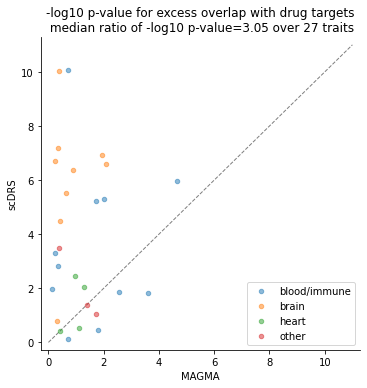

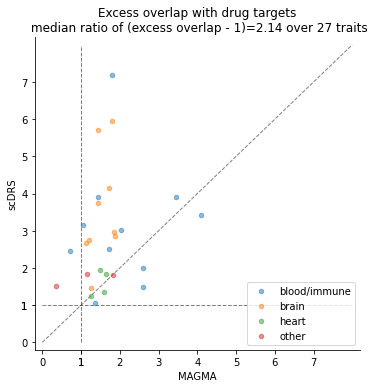

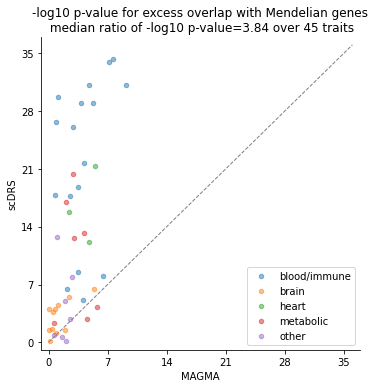

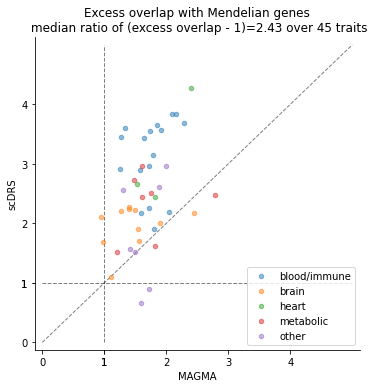

In [11]:
res_ref = 'gwas'
for gold_gs in ['ref_drug', 'ref_mende']:
    for plot_term in ['nlog10pval', 'excess_overlap']:
        trait_list = sorted(set(dic_stats['%s.%s'%(res_ref,gold_gs)].index) & 
                            set(dic_stats['scdrs.%s'%gold_gs].index))
        median_ratio = (dic_stats['scdrs.%s'%gold_gs].loc[trait_list, plot_term] /
                        dic_stats['%s.%s'%(res_ref,gold_gs)].loc[trait_list, plot_term]).median()  
        
        if plot_term=='nlog10pval':
            median_ratio = (dic_stats['scdrs.%s'%gold_gs].loc[trait_list, plot_term] /
                        dic_stats['%s.%s'%(res_ref,gold_gs)].loc[trait_list, plot_term]).median()  
            title_str = '%s with %s\n median ratio of -log10 p-value=%0.2f over %d traits'\
                %(dic_name[plot_term], dic_name[gold_gs], median_ratio, len(trait_list))
        elif  plot_term=='excess_overlap':
            median_ratio = ((dic_stats['scdrs.%s'%gold_gs].loc[trait_list, plot_term]-1).clip(lower=0.01) /
                        (dic_stats['%s.%s'%(res_ref,gold_gs)].loc[trait_list, plot_term]-1).clip(lower=0.01)).median()
            title_str = '%s with %s\n median ratio of (excess overlap - 1)=%0.2f over %d traits'\
                %(dic_name[plot_term], dic_name[gold_gs], median_ratio, len(trait_list))
        else:
            median_ratio=0

        plt.figure(figsize=[5.2,5.5])
        ax = plt.subplot(1,1,1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        for cate in sorted(DF_TRAIT_INFO['Category'].unique()):
            trait_list_cate = sorted(set(trait_list) & set(DF_TRAIT_INFO.index[DF_TRAIT_INFO['Category']==cate]))
            if len(trait_list_cate)==0:
                continue
            plt.scatter(dic_stats['%s.%s'%(res_ref,gold_gs)].loc[trait_list_cate, plot_term], 
                        dic_stats['scdrs.%s'%gold_gs].loc[trait_list_cate, plot_term],
                        s=20, alpha=0.5, label=cate)
        
        # Annotate traits
        for trait in trait_list:
            x_val = dic_stats['%s.%s'%(res_ref,gold_gs)].loc[trait, plot_term]
            y_val = dic_stats['scdrs.%s'%gold_gs].loc[trait, plot_term]
            if x_val-y_val>3:
                plt.text(x_val+0.25, y_val, DF_TRAIT_INFO.loc[trait, 'Code'], 
                         color='k', weight="normal", zorder=10)
        
        xmin,xmax = plt.xlim()
        ymin,ymax = plt.ylim()
        max_ = np.ceil(max(xmax, ymax)).astype(int)
        plt.plot([0, max_], [0, max_], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
        plt.xlim([-max_*0.025, max_*1.025])
        plt.ylim([-max_*0.025, max_*1.025])
        step_ = max(1, int((max_ - 0)/5))
        tick_list = list(np.arange(0, max_, step_))
        if plot_term == 'excess_overlap':
            plt.plot([0, max_], [1, 1], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
            plt.plot([1, 1], [0, max_], '--', color='k', alpha=0.5, zorder=0, linewidth=1)
            tick_list = sorted(tick_list + [1])       
        plt.xticks(tick_list, tick_list)
        plt.yticks(tick_list, tick_list)
        plt.xlabel(dic_name[res_ref])
        plt.ylabel(dic_name['scdrs'])       
        plt.title(title_str)
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.savefig(FIG_PATH+'/comparison_gs.%s.%s.svg'%(gold_gs,plot_term))
        plt.show()

In [12]:
# Supp. Table dic_stats.keys()
df_res = pd.DataFrame(index=sorted(TRAIT_LIST_GOLD))
df_res = df_res.join(DF_TRAIT_INFO[['Trait_Identifier', 'Code']])
for gold_gs in ['ref_drug', 'ref_mende']:
    for res in ['scdrs', 'gwas']:
        temp_df = dic_stats['%s.%s'%(res,gold_gs)][['excess_overlap', 'nlog10pval']].copy()
        temp_df.columns = ['%s.%s.%s'%(res, gold_gs, x) for x in temp_df.columns]
        df_res = df_res.join(temp_df)
df_res.to_csv(DATA_PATH+'/supp_table.rv1/supp_tab_fig4d.tsv', sep='\t', index=False)        

In [13]:
# Find scDRS only examples
for trait in dic_stats['scdrs.ref_drug'].index:
    # Get scDRS-only gs  
    gs_scdrs = dic_gs['%s.scdrs'%trait] & BACKGRD_SET
    gs_gwas = dic_gs['%s.gwas'%trait] & BACKGRD_SET
    gs_set_ref = dic_gs['%s.ref_drug'%trait] & BACKGRD_SET
    gs = (gs_scdrs-gs_gwas) & gs_set_ref
    
    # MAGMA RANK 
    df_res = DF_MAGMA[[trait]].copy()
    df_res.columns = ['p.magma']
    df_res.sort_values('p.magma', inplace=True)
    df_res['rank.magma'] = np.arange(df_res.shape[0])+1
    
    # scDRS RANK
    temp_df = df_corr_scdrs[[trait]].copy()
    temp_df.columns = ['corr.scdrs']
    temp_df.sort_values(by='corr.scdrs', ascending=False, inplace=True)
    temp_df['rank.scdrs'] = np.arange(temp_df.shape[0])+1
    
    df_res = df_res.join(temp_df)
    df_res = df_res.loc[[x in gs for x in df_res.index]]
    df_res = df_res.loc[df_res['rank.scdrs']<500]
    df_res.sort_values('rank.scdrs', inplace=True)
    
    if df_res.shape[0]>0:
        print('# %s'%(trait))
        display(df_res)

# PASS_CD_deLange2017


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Itgb7,0.418250,8857,0.307985,14.0
Il2rb,0.945580,14461,0.225119,75.0
Ms4a1,0.131010,4472,0.203539,118.0
Cd3g,0.007588,1182,0.189272,161.0
Jak1,0.238510,6336,0.183954,176.0
Cd3d,0.005266,1049,0.178819,188.0
Il17ra,0.230740,6205,0.176894,199.0
S1pr4,0.568570,10691,0.168601,234.0
Cd3e,0.044244,2572,0.165379,248.0
Btk,NaN,15488,0.154064,300.0


# PASS_Celiac


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Itgb7,0.26004,4968,0.232896,26.0
Il2rb,0.58831,9628,0.231657,30.0
Itga4,0.11123,2499,0.172031,103.0


# PASS_IBD_deLange2017


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Itgb7,0.537340,10565,0.310242,11.0
Jak1,0.058314,3221,0.163539,209.0
Tnf,NaN,15104,0.145937,287.0
S1pr4,0.508850,10235,0.132849,366.0


# PASS_Lupus


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Ms4a1,0.447490,8476,0.322480,17.0
Syk,0.310570,6562,0.250977,69.0
Cd22,0.674660,11471,0.247830,73.0
Btk,NaN,15488,0.189036,155.0
Cd86,0.205120,4833,0.161795,247.0
S1pr4,0.086467,2608,0.149568,302.0
Il2rb,0.120840,3288,0.147968,310.0
Pold4,0.974460,14667,0.139437,343.0
Icos,0.275960,6014,0.138267,353.0
Cd28,0.162820,4064,0.130293,391.0


# PASS_Multiple_sclerosis


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Itgb7,0.240960,4461,0.358328,25.0
Itga4,0.691490,10798,0.282347,82.0
S1pr4,0.230540,4301,0.263335,113.0
Cd19,NaN,14743,0.245334,151.0
Ms4a1,0.303570,5373,0.240789,160.0
Kcna3,0.721180,11195,0.184626,328.0
Ccr2,NaN,14898,0.164358,410.0
Top2a,0.089868,2099,0.156268,453.0


# PASS_Primary_biliary_cirrhosis


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Ms4a1,0.146010,3217,0.337934,28.0
Cd86,0.050505,1554,0.151690,369.0


# PASS_Rheumatoid_Arthritis


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Ltb,NaN,15062,0.408964,17.0
Cd3e,0.977020,14412,0.371992,22.0
Itk,0.709310,11198,0.259682,97.0
Ms4a1,0.404880,7208,0.256150,104.0
Itga4,0.755770,11762,0.252765,109.0
Cd4,0.837650,12799,0.246856,119.0
Txk,0.034772,1261,0.228586,152.0
Itgal,0.062985,1854,0.212947,181.0
Pik3cd,0.097592,2507,0.210037,192.0
Syk,0.656510,10581,0.207277,200.0


# PASS_UC_deLange2017


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Itgb7,0.850190,13538,0.227286,23.0
Cd3e,0.127570,4059,0.175299,90.0
Itga4,0.030159,1825,0.174681,94.0
Prkcd,0.309160,7011,0.168301,109.0
Mmp9,0.175940,4903,0.164179,122.0
Il2rb,0.026356,1691,0.150664,165.0
Mmp8,0.617640,11015,0.140211,213.0
Itk,0.036574,1990,0.138193,229.0
Alox5,0.023803,1633,0.133389,261.0
Tnf,NaN,15104,0.124794,308.0


# UKB_460K.disease_AID_ALL


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Itgb7,0.41194,8195,0.377909,13.0
Cd3e,0.22533,5595,0.323268,37.0
Itga4,0.16268,4558,0.278572,76.0
Itgal,0.63712,10981,0.247699,117.0
S1pr4,0.47966,9076,0.235018,136.0
Ms4a1,0.98682,14836,0.157980,378.0
Il17ra,0.30607,6755,0.151352,407.0
Ifng,0.11075,3661,0.150035,413.0
Jak3,0.10086,3423,0.144503,446.0


# UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Jak1,0.25581,7574,0.151081,286.0
Ppia,0.21811,6962,0.120068,446.0


# UKB_460K.disease_ASTHMA_DIAGNOSED


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Cd6,0.288070,7596,0.270062,35.0
Kcnn4,0.944260,14513,0.197426,147.0
Tubb5,NaN,15088,0.189951,165.0
Jak1,0.002637,981,0.186232,176.0
S1pr4,0.028131,2432,0.175593,197.0


# PASS_ADHD_Demontis2018


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Gria2,0.078712,2301,0.166399,3.0
Grin2b,0.419760,7864,0.120957,60.0
Grin1,0.324410,6461,0.119177,66.0
Scn8a,0.388000,7419,0.105663,135.0
Gabrg2,0.802880,12567,0.098668,191.0
Scn1a,0.525480,9244,0.091153,271.0
Gabrb1,0.027698,1185,0.080768,441.0


# PASS_Alzheimers_Jansen2019


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Lyn,0.130510,3020,0.191689,40.0
Hck,0.595480,9997,0.188258,44.0
Csf3r,0.084686,2159,0.173567,56.0
Ptgs1,0.362020,6655,0.166719,70.0
Adrb2,0.431800,7675,0.137931,127.0
Fgr,0.870940,13471,0.130860,149.0
Adora3,0.561910,9541,0.115192,206.0
Cysltr1,NaN,15452,0.098020,319.0
Pah,0.989500,14830,0.089206,394.0
Adrb1,0.224180,4580,0.082258,458.0


# PASS_BIP_Mullins2021


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Gria2,0.003308,1130,0.291208,7.0
Sv2a,0.057648,3608,0.222846,58.0
Grin1,0.344600,8614,0.198481,112.0
Grin2b,0.029984,2703,0.194452,125.0
Gabrb3,0.019787,2304,0.175643,179.0
Gabra4,0.007986,1594,0.170680,194.0
Scn8a,0.139090,5475,0.170423,197.0
Gabra1,0.005124,1342,0.163398,238.0
Gabrb1,0.006807,1496,0.163236,239.0
Cnr1,0.545790,10958,0.160020,254.0


# PASS_DrinksPerWeek_Liu2019


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Gria2,0.825690,11647,0.186721,68.0
Gabra1,0.362630,6525,0.132452,205.0
Gabrb2,0.186910,4273,0.124490,245.0
Gabrg2,0.455650,7677,0.120016,276.0
Grin1,0.417020,7204,0.118812,285.0
Cnr1,0.089905,2742,0.118620,290.0
Grin2b,0.145340,3669,0.118167,293.0
Scn8a,0.176280,4127,0.114799,312.0
Scn1a,0.232370,4895,0.108914,358.0
Gria4,0.456490,7688,0.108747,359.0


# PASS_Insomnia_Jansen2019


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Gabra1,0.119960,3772,0.137791,285.0
Gabrb2,0.104850,3481,0.132988,311.0
Ptgs1,0.922750,14187,0.132764,313.0
Scn8a,0.833690,13273,0.132105,318.0
Gabrg2,0.018702,1230,0.131718,322.0
Gabrb3,0.342480,7530,0.124874,379.0
Cacng3,0.174290,4823,0.123366,392.0
Gabra4,0.391370,8192,0.121418,407.0
Scn1a,0.863730,13579,0.119799,424.0
Gabrb1,0.090527,3169,0.117419,448.0


# PASS_Intelligence_SavageJansen2018


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Gabrb3,0.001399,1408,0.196684,137.0
Gabra1,0.734520,13356,0.163518,271.0
Gabrb1,0.004804,2055,0.163359,274.0
Gabrb2,0.003403,1839,0.163284,275.0
Gabrg2,0.015174,2995,0.156408,304.0
Gabrg1,0.358120,9778,0.137482,414.0


# PASS_MDD_Howard2019


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Gria2,0.381530,8312,0.296455,5.0
Snap25,0.968140,14610,0.264384,20.0
Adora1,0.216950,5966,0.225096,55.0
Atp1a2,0.162690,5040,0.199623,108.0
Grm3,0.016900,1535,0.191549,135.0
Grin2b,0.029336,1990,0.190505,142.0
Gabrb2,0.036213,2223,0.186499,158.0
Grin1,0.035022,2181,0.181769,177.0
Gabrg2,0.053551,2738,0.174322,206.0
Scn8a,0.500440,9786,0.172846,213.0


# PASS_Schizophrenia_Pardinas2018


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Gria2,0.349880,9015,0.320202,3.0
Slc6a1,0.045145,3891,0.284803,19.0
Tubb4a,NaN,14702,0.242743,59.0
Sv2a,0.030309,3298,0.229059,82.0
Grin1,NaN,15171,0.196352,170.0
Tuba1a,0.763670,12707,0.195094,174.0
Gabrb3,0.020067,2864,0.194663,178.0
Scn8a,0.007643,2041,0.185214,214.0
Gabra1,0.219350,7387,0.179405,241.0
Grin2b,0.070711,4656,0.176043,258.0


# UKB_460K.body_BMIz


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Snap25,4.981700e-03,4401,0.329038,8.0
Gria2,7.107300e-03,4716,0.315187,15.0
Adora1,1.455600e-01,9556,0.235911,101.0
Grin1,6.437900e-01,13646,0.218820,134.0
Scn8a,6.088600e-02,7692,0.202956,189.0
Gabrb3,8.713000e-06,1556,0.201792,193.0
Grin2b,7.570000e-04,3132,0.187107,252.0
Gabrb2,1.142500e-03,3355,0.185224,259.0
Sstr3,1.172000e-02,5223,0.184966,261.0
Gabra1,2.070400e-02,5928,0.183487,269.0


# PASS_AtrialFibrillation_Nielsen2018


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Kcng2,0.20826,5989,0.115894,169.0
Kcnj3,0.33893,8019,0.105700,215.0
Kcna5,0.29583,7371,0.104615,225.0
P2ry12,0.16027,5169,0.084225,414.0


# PASS_Coronary_Artery_Disease


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Tnni3,0.028757,936,0.157920,23.0
Tnnt2,0.507600,8450,0.157223,25.0
Tnnc1,0.961710,14158,0.140795,56.0
Ace,0.573790,9362,0.114665,187.0
Scn7a,0.808450,12403,0.109074,213.0
Xdh,0.095985,2146,0.104680,258.0
Npr1,0.161770,3287,0.095663,356.0
Kcnk3,0.767130,11897,0.095197,360.0
Fkbp1a,0.823970,12616,0.088120,450.0


# UKB_460K.disease_CARDIOVASCULAR


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Tnni3,0.231150,8651,0.143210,44.0
Tnnt2,0.204020,8274,0.141578,50.0
Tnnc1,0.322880,9829,0.121970,119.0
Scn7a,0.092570,6125,0.106309,203.0
Ptgs1,0.744120,13545,0.103585,220.0
P2ry12,0.041648,4664,0.102583,226.0
Impdh1,0.738350,13502,0.102209,229.0
Cpt1b,0.027134,4033,0.094837,290.0
Slc12a1,0.291520,9442,0.090737,327.0


# UKB_460K.disease_HYPERTENSION_DIAGNOSED


,p.magma,rank.magma,corr.scdrs,rank.scdrs
P2ry12,0.026207,4315,0.192312,33.0
Ptgs1,0.481620,11700,0.180685,55.0
Scn7a,0.001438,2037,0.151183,150.0
Slc29a1,0.017740,3851,0.128317,299.0
Cd86,0.001506,2067,0.113472,444.0


# PASS_Type_1_Diabetes


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Cd2,0.592270,9773,0.268990,4.0
Cd3e,0.135350,3154,0.212881,29.0
Prkcb,0.812600,12521,0.157134,110.0
Jak1,0.027407,1060,0.134795,186.0
Cd86,0.424100,7497,0.119119,265.0
Itgal,0.654170,10594,0.116101,282.0
Abcc8,0.147650,3398,0.091497,492.0


# PASS_Type_2_Diabetes


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Abcc8,0.031180,921,0.256705,12.0
Acly,0.681120,10818,0.129779,188.0
Car4,0.998830,14621,0.125767,210.0
Fkbp1a,0.668950,10634,0.120469,244.0
Scn9a,0.925380,13887,0.115863,279.0
Gaa,0.076361,1827,0.096963,428.0


# UKB_460K.cancer_BREAST


,p.magma,rank.magma,corr.scdrs,rank.scdrs
Mmp2,0.641700,10409,0.205288,38.0
Pdgfra,0.273960,5122,0.180917,88.0
Fgfr1,0.081592,1868,0.165467,124.0
Ctsk,0.255340,4816,0.159782,142.0
Mfge8,0.733900,11581,0.133023,222.0
Fzd1,0.344790,6200,0.129048,234.0
Scn7a,0.512910,8613,0.128695,235.0
Pdgfrb,0.765680,11997,0.128547,237.0
Rarg,0.134260,2854,0.125600,251.0
Tgfb3,0.669100,10791,0.122135,275.0
